<a href="https://colab.research.google.com/github/farhan1503001/Satelite-Image-Segmentation/blob/main/Land_Cover_Satelite_Image_Segmentation_Using_Sentinel_2_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing the libraries
!pip install patchify
!pip install segmentation_models
!pip install numba

In [2]:
import os
import cv2
import numpy as np
from patchify import patchify
import tensorflow as tf
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from matplotlib import pyplot as plt
scaler=MinMaxScaler()

Segmentation Models: using `keras` framework.


In [3]:
root_directory='/content/drive/MyDrive/Dataset'

patch_size=256

In [4]:
image_directory='/content/drive/MyDrive/Dataset/Image'
mask_directory='/content/drive/MyDrive/Dataset/Mask'

In [5]:
print(sorted(os.listdir(image_directory)))
print(sorted(os.listdir(mask_directory)))

['Image0.png', 'Image1.png', 'Image10.png', 'Image100.png', 'Image1000.png', 'Image1001.png', 'Image1002.png', 'Image1003.png', 'Image1004.png', 'Image1005.png', 'Image1006.png', 'Image1007.png', 'Image1008.png', 'Image1009.png', 'Image101.png', 'Image1010.png', 'Image1011.png', 'Image1012.png', 'Image1013.png', 'Image1014.png', 'Image1015.png', 'Image1016.png', 'Image1017.png', 'Image1018.png', 'Image1019.png', 'Image102.png', 'Image1020.png', 'Image1021.png', 'Image1022.png', 'Image1023.png', 'Image1024.png', 'Image1025.png', 'Image1026.png', 'Image1027.png', 'Image1028.png', 'Image1029.png', 'Image103.png', 'Image1030.png', 'Image1031.png', 'Image1032.png', 'Image1033.png', 'Image1034.png', 'Image1035.png', 'Image1036.png', 'Image1037.png', 'Image1038.png', 'Image1039.png', 'Image104.png', 'Image1040.png', 'Image1041.png', 'Image1042.png', 'Image1043.png', 'Image1044.png', 'Image1045.png', 'Image1046.png', 'Image1047.png', 'Image1048.png', 'Image1049.png', 'Image105.png', 'Image1050

In [6]:
length_i=len(os.listdir(image_directory))
length_m=len(os.listdir(mask_directory))
print(length_i)
print(length_m)

1600
1590


In [7]:
#Now reading image and mask
image_list=[]
mask_list=[]
for i in range(length_i):
   image_path=os.path.join(image_directory,"Image"+str(i)+'.png')
   mask_path=os.path.join(mask_directory,"Mask"+str(i)+'.png')

   image=cv2.imread(image_path,1)
   mask=cv2.imread(mask_path,1)
   if image is None or mask is None:
     print("Problem Erupted")
     break
   image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
   mask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
   image=np.array(image)
   mask=np.array(mask)
   image_list.append(image)
   mask_list.append(mask)

Problem Erupted


In [8]:
#now converting both lists to numpy array
image_list=np.array(image_list)
mask_list=np.array(mask_list)

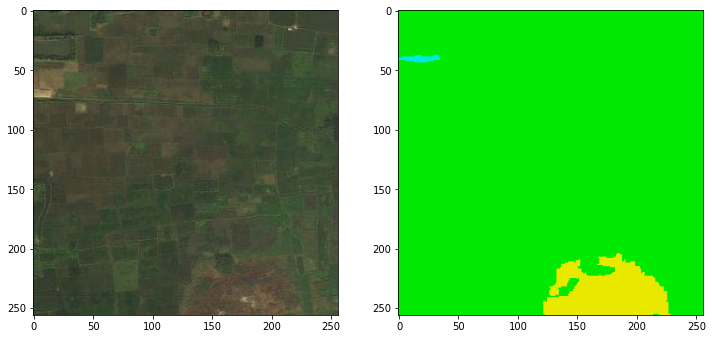

In [9]:
#Now visualizing some images and their corresponding masks for sanity check
import random
image_num=random.randint(0,len(image_list))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_list[image_num], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_list[image_num], (patch_size, patch_size, 3)))
plt.show()

**Finding unique pixel values of the dataset**

In [10]:
def find_color_pixels(mask):
    #Using these function we will try to find out the uniques colors in a image
    print("Finding the mask unique pixel values")
    new_shape_mask=np.unique(mask.reshape(-1,mask.shape[2]),axis=0)
    print(new_shape_mask)
def find_color_second_method(image):
    print("Color pixel values in another way")
    unique_pixels=set( tuple(v) for m2d in image for v in m2d ) 
    print("Unique pixel are: ")
    print(unique_pixels)

In [11]:
mask=cv2.imread('/content/drive/MyDrive/output.png',1)
if mask is not None:
        print("Image reading completed successfully")
        find_color_pixels(mask)
        find_color_second_method(mask)
else:
        print("Sorry!! Couldn't read actually")

Image reading completed successfully
Finding the mask unique pixel values
[[  0   0   0]
 [  0   0 233]
 [  0 233   0]
 [  0 233 233]
 [233   0   0]
 [233 233   0]]
Color pixel values in another way
Unique pixel are: 
{(233, 0, 0), (0, 233, 233), (0, 233, 0), (0, 0, 233), (233, 233, 0), (0, 0, 0)}


***So we find from the exercise that there are six unique pixel values or six unique labels in this dataset of which blue indicates water,green indicates greenary,red indicates building,yellow indicates marshlands***

In [12]:
import numpy as np
from numba import jit

@jit(nopython=True)
def im2index(im):
    
    """
    turn a 3 channel RGB image to 1 channel index image
    """
    counter = 0
    counter1 = 0
    print(im.shape)
    assert len(im.shape) == 3
    height, width, ch = im.shape
    assert ch == 3
    m_lable = np.zeros((height, width), dtype=np.uint8)
    for h in range(height):
        for w in range(width):
            #Unknown
            if im[h, w, 0] == 0 and im[h, w, 1] == 0 and im[h, w, 2] == 0:
                m_lable[h, w] = 0
                counter1 = counter1 +1
            #Forest
            elif im[h, w, 0] == 0 and im[h, w, 1] == 0 and im[h, w, 2] == 233:
                m_lable[h, w] = 1
                counter1 = counter1 +1
            #Built-Up
            elif im[h, w, 0] == 0 and im[h, w, 1] == 233 and im[h, w, 2] == 0:
                m_lable[h, w] = 2
                counter1 = counter1 +1
            #Water
            elif im[h, w, 0] == 0 and im[h, w, 1] == 233 and im[h, w, 2] == 233:
                m_lable[h, w] = 3
                counter1 = counter1 +1
            #Farmland
            elif im[h, w, 0] == 233 and im[h, w, 1] == 0 and im[h, w, 2] == 0:
                m_lable[h, w] = 4
                counter1 = counter1 +1
            #Meadow
            elif im[h, w, 0] == 233 and im[h, w, 1] == 233 and im[h, w, 2] == 0:
                m_lable[h, w] = 5
                counter1 = counter1 +1
    print(counter)
    print(counter1)
    return m_lable

In [13]:
#Now we will convert all the masks to labels
labels=[]
for i in range(mask_list.shape[0]):
  temp_label=im2index(mask_list[i])
  labels.append(temp_label)
#Now converting labels into a numpy array
labels=np.array(labels)
labels=np.expand_dims(labels,axis=3)

print("Unique labels in this dataset are ",np.unique(labels))

(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256, 3)
0
65536
(256, 256,

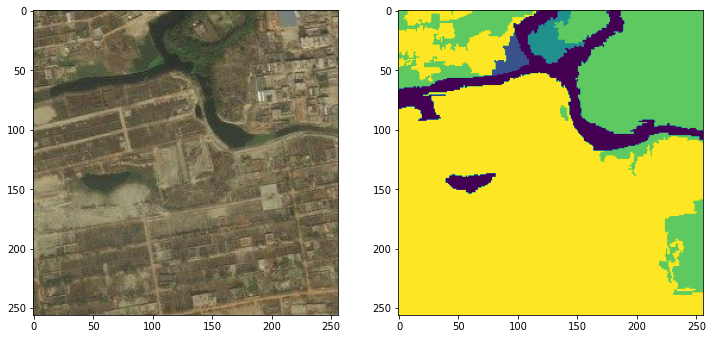

In [14]:
#Another sanity check
import random
import numpy as np
image_number = random.randint(0, len(image_list))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_list[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [15]:
#Now one hot encoding format will be used by me.
num_classes=len(np.unique(labels))
print(num_classes)
from tensorflow.keras.utils import to_categorical
labels_cat=to_categorical(labels,num_classes=num_classes)

6


In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(image_list,labels_cat,test_size=0.05,random_state=42)
del image_list
del mask_list
del labels
del labels_cat
del mask

In [17]:
#Now determining loss function and weights
weights=[0.1666,0.1666,0.1666,0.16666,0.16666,0.16666]

dice_loss=sm.losses.DiceLoss(class_weights=weights)
focal_loss=sm.losses.CategoricalFocalLoss()
total_loss=dice_loss+(1*focal_loss)

In [18]:
img_height=x_train.shape[1]
img_width=x_train.shape[2]
img_channels=x_train.shape[3]
#Checking everything
print(x_train.shape)

(1510, 256, 256, 3)


**Deep Lab V3+ Model**

In [19]:
from tensorflow.keras.layers import  Conv2D,BatchNormalization,UpSampling2D,Concatenate,Activation,AveragePooling2D
import os
from tensorflow.keras.layers import Input,Conv2DTranspose
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

#Pyramid pooling aspp
#image_pooling->1d conv-->dilated conv with b8=>16=>32
def ASPP(inputs):
  #First entire shape pooling
  shape=inputs.shape
  y_pool=AveragePooling2D(pool_size=(shape[1],shape[2]),name='average_pooling')(inputs)
  y_pool=Conv2D(filters=256,kernel_size=1,use_bias=False,padding='same')(y_pool)
  y_pool=BatchNormalization()(y_pool)
  y_pool=Activation(activation='relu')(y_pool)
  y_pool=UpSampling2D(size=(shape[1],shape[2]),interpolation='bilinear')(y_pool)
  #print(y_pool.shape)

  #Now 1-d Channelwise convolution
  y_1=Conv2D(filters=256,kernel_size=1,use_bias=False,padding='same',dilation_rate=1)(inputs)
  y_1=BatchNormalization()(y_1)
  y_1=Activation(activation='relu')(y_1)
  #Now with dilationrate=6
  y_6=Conv2D(filters=256,kernel_size=3,use_bias=False,padding='same',dilation_rate=6)(inputs)
  y_6=BatchNormalization()(y_6)
  y_6=Activation(activation='relu')(y_6)

  #Now with dilationrate=12
  y_12=Conv2D(filters=256,kernel_size=3,use_bias=False,padding='same',dilation_rate=12)(inputs)
  y_12=BatchNormalization()(y_12)
  y_12=Activation(activation='relu')(y_12)

  #Now with dilation rate=18
  y_18=Conv2D(filters=256,kernel_size=3,use_bias=False,padding='same',dilation_rate=18)(inputs)
  y_18=BatchNormalization()(y_18)
  y_18=Activation(activation='relu')(y_18)

  y=Concatenate()([y_pool,y_1,y_6,y_12,y_18])
  #1-d convolution application
  y=Conv2D(filters=256,kernel_size=1,padding='same',dilation_rate=1,use_bias=False)(y)
  y=BatchNormalization()(y)
  y=Activation(activation='relu')(y)
  print(y.shape)
  return y
def DeepLabv3plus(shape):
  """
  input shape is given as a tuple generate a deeplabv3 model
  """
  input1=Input(shape)
  base_model=ResNet50(include_top=False,weights='imagenet',input_tensor=input1)

  image_features=base_model.get_layer('conv4_block6_out').output

  #Now we will perform atrous asymmetric pyramid pooling
  x_a=ASPP(image_features)
  x_a=UpSampling2D(size=(4,4),interpolation='bilinear')(x_a)
  #Now we will get low level features from our resnet model
  x_b=base_model.get_layer('conv2_block2_out').output
  x_b=Conv2D(filters=48,kernel_size=1,padding='same',use_bias=False)(x_b)
  x_b=BatchNormalization()(x_b)
  x_b=Activation(activation='relu')(x_b)
  #Now we will concatenate
  x=Concatenate()([x_a,x_b])
  print(x.shape)
  #Now apply convolutional layer with 3*3 filter 2 times
  x=Conv2D(filters=256,kernel_size=1,padding='same',use_bias=False)(x)
  x=BatchNormalization()(x)
  x=Activation(activation='relu')(x)

  x=Conv2D(filters=256,kernel_size=1,padding='same',use_bias=False)(x)
  x-BatchNormalization()(x)
  x=Activation(activation='relu')(x)

  x=UpSampling2D(size=(4,4),interpolation='bilinear')(x)
  print(x.shape)
  #outputs
  x=Conv2D(6,(1,1),name='output_layer')(x)
  x=Activation(activation='softmax')(x)
  print(x.shape)
  #Model
  model=Model(inputs=input1,outputs=x)
  return model
if __name__=='__main__':
  shape=(256,256,3)
  model=DeepLabv3plus(shape)
  #model.summary()

(None, 16, 16, 256)
(None, 64, 64, 304)
(None, 256, 256, 256)
(None, 256, 256, 6)


In [20]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [21]:
#Now defining metrices for your evaluation
metrics=['accuracy',jacard_coef]

In [22]:
model=DeepLabv3plus((256,256,3))
model.compile(optimizer='adam',loss=total_loss,metrics=metrics)
model.summary()

(None, 16, 16, 256)
(None, 64, 64, 304)
(None, 256, 256, 256)
(None, 256, 256, 6)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
          

In [23]:
#Now running the model
history1=model.fit(x_train,y_train,batch_size=8,verbose=1,epochs=35,validation_data=(x_test,y_test),shuffle=False)

Epoch 1/35
189/189 [==============================] - 99s 398ms/step - loss: 0.9608 - accuracy: 0.6457 - jacard_coef: 0.3867 - val_loss: 1.0088 - val_accuracy: 0.3271 - val_jacard_coef: 0.1922
Epoch 2/35
189/189 [==============================] - 56s 296ms/step - loss: 0.9523 - accuracy: 0.6820 - jacard_coef: 0.4249 - val_loss: 0.9825 - val_accuracy: 0.4522 - val_jacard_coef: 0.2662
Epoch 3/35
189/189 [==============================] - 48s 253ms/step - loss: 0.9468 - accuracy: 0.7063 - jacard_coef: 0.4544 - val_loss: 0.9675 - val_accuracy: 0.5942 - val_jacard_coef: 0.3413
Epoch 4/35
189/189 [==============================] - 48s 256ms/step - loss: 0.9438 - accuracy: 0.7174 - jacard_coef: 0.4704 - val_loss: 0.9619 - val_accuracy: 0.6436 - val_jacard_coef: 0.3812
Epoch 5/35
189/189 [==============================] - 48s 255ms/step - loss: 0.9409 - accuracy: 0.7289 - jacard_coef: 0.4857 - val_loss: 0.9662 - val_accuracy: 0.5969 - val_jacard_coef: 0.3392
Epoch 6/35
189/189 [===============

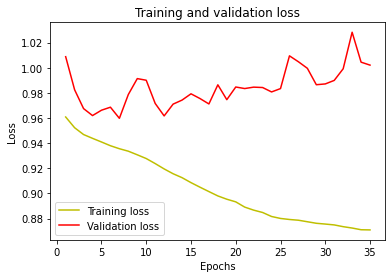

In [32]:
#Now visualizing training and validation loss
train_loss=history1.history['loss']
val_loss=history1.history['val_loss']
epochs=range(1,len(train_loss)+1)
plt.plot(epochs,train_loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

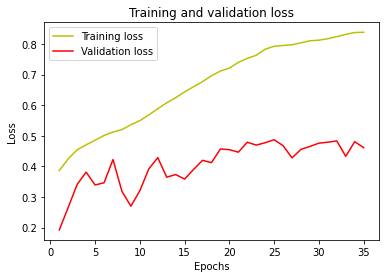

In [33]:
#Now saving our model and checking the output
train_jac=history1.history['jacard_coef']
val_jac=history1.history['val_jacard_coef']
plt.plot(epochs,train_jac, 'y', label='Training loss')
plt.plot(epochs, val_jac, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:


#Now measuring the IOU
#At first finding the prediction output
y_pred=model.predict(x_test)
y_pred_max=np.argmax(y_pred,axis=3)
y_test_max=np.argmax(y_test,axis=3)



In [35]:
#importing IOU
from keras.metrics import MeanIoU
iou_mapper=MeanIoU(num_classes=num_classes)
iou_mapper.update_state(y_test_max,y_pred_max)
print("Mean IOU is: ",iou_mapper.result().numpy())

Mean IOU is:  0.35297862


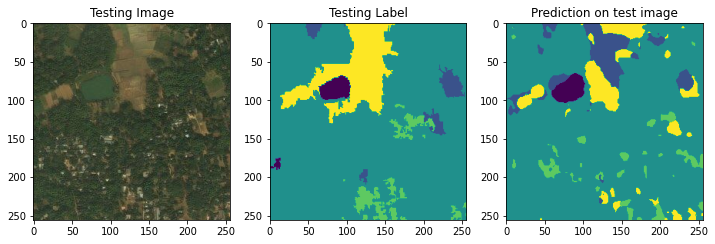

In [36]:
import random

test_img_number=random.randint(0,len(x_test))
test_img=x_test[test_img_number]

test_ground=y_test_max[test_img_number]

test_image_input=np.expand_dims(test_img,0)

prediction=(model.predict(test_image_input))
predicted_image=np.argmax(prediction,axis=3)[0,:,:]
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_ground)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_image)
plt.show()
